In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
data = pd.read_csv('housing.csv')
data.info()

In [ ]:
# cleaned data
print(data['total_bedrooms'].hasnans)
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())
data.dropna(inplace=True)
print(data['total_bedrooms'].hasnans)

In [ ]:
data.info()

In [ ]:
# median house value is the target value 
# the rest are training features/set
from sklearn.model_selection import train_test_split
X = data.drop(['median_house_value'],axis=1)
y =data['median_house_value']

In [ ]:
train_data = X.join(y)
train_data

In [ ]:
# data visualizatoin
train_data.hist(figsize=(12,8))

In [ ]:
# more data visualization using seabonr
plt.figure(figsize=(12,8))
sns.heatmap(train_data.loc[:,train_data.columns != "ocean_proximity"].corr(),annot=True)

In [ ]:
# adjustings the histograms to try to achieve more of a bell curve to find a correlation
# and to see if feature engineering is necessary
train_data['total_rooms'] = np.log(train_data['total_rooms']+1)
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms']+1)
train_data['population'] = np.log(train_data['population']+1)
train_data['households'] = np.log(train_data['households']+1)


In [ ]:
# after adjusting data skewed
# bell curved is achieved in four features
train_data.hist(figsize=(12,8))

In [ ]:
# heatmap visualization after adjusting data
plt.figure(figsize=(12,8))
sns.heatmap(train_data.loc[:,train_data.columns != "ocean_proximity"].corr(),annot=True)

In [ ]:
# getting value counts to object data
train_data.ocean_proximity.value_counts()

In [ ]:
#getting binary values for object data to normalize later
pd.get_dummies(train_data.ocean_proximity)

In [ ]:
# joining converted data to the dataset to visulize
train_data= train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)
train_data

In [ ]:
# data visualized to heapmap
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(),annot=True)

In [ ]:
# scatter plot to highlight what data seems to be 
# more affected by location to find further visualization 
plt.figure(figsize=(15,8))
sns.scatterplot(x='latitude',y='longitude',data=train_data, hue='median_house_value', palette='coolwarm')

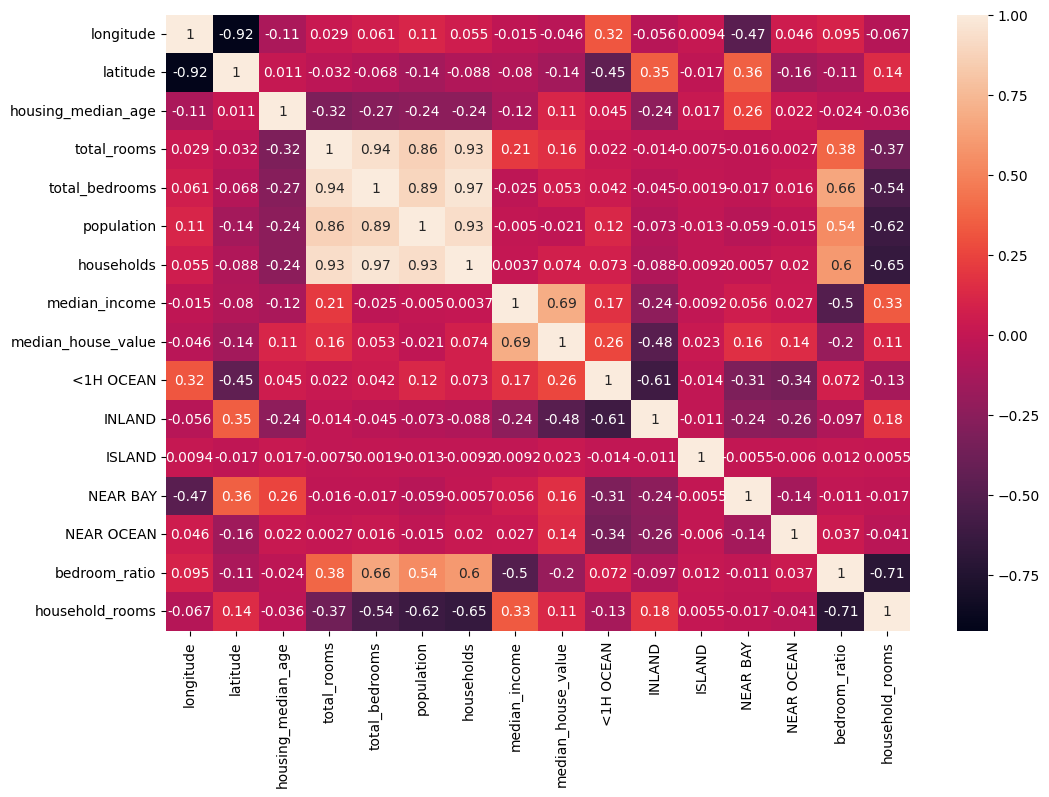

In [69]:

# engineering more features to look at the ratios for bedrooms to total rooms and 
# total rooms to households to see how they correlate to each other
train_data['bedroom_ratio'] = train_data['total_bedrooms']/train_data['total_rooms']
train_data['household_rooms'] =train_data['total_rooms'] / train_data['households']
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(),annot=True)

In [70]:
# linear regression testing 
# Note: not the best type of regressison for this data set
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(train_data.drop(['median_house_value'],axis=1),train_data['median_house_value'], test_size=.2)
scalar= StandardScaler()
x_train_s=scalar.fit_transform(X_train)
reg = LinearRegression()
reg.fit(x_train_s,y_train)


LinearRegression()

In [71]:
#scaled the test and training data for a more accurate representation
# of test results
x_test_s = scalar.fit_transform(X_test)

In [72]:
# test results for linear regression 
print("train: ",reg.score(x_train_s,y_train))
test_score = reg.score(x_test_s,y_test)
while test_score <0:
    test_score = reg.score(x_test_s,y_test)
print("test: ",test_score)




train:  0.6689899056090532
test:  0.6642890138810416


In [73]:
# random forest regressor to examine
# differences between linear and random forest regression
from sklearn.ensemble import RandomForestRegressor

scaler =StandardScaler()
X_test_s = scaler.fit_transform(X_test)
X_train_s =scaler.fit_transform(X_train)
forest = RandomForestRegressor()

forest.fit(X_train_s,y_train)

RandomForestRegressor()

In [74]:
# large difference between linear regression and random forest
# without optimizations

print("train: ", forest.score(X_train_s,y_train))
print("test: ",forest.score(X_test_s,y_test))

train:  0.9744086287904574
test:  0.7939939083320287


In [75]:
# using GridSearchCV to find optimization hyperparameters
# used documentation from  RandomForestRegressor to choose the best
# hypterparameters to use for param_grid and used the negative mean squared error alg to return
# the best estimators
from sklearn.model_selection import GridSearchCV
forest = RandomForestRegressor()
param_grid = {
    "n_estimators": [50,100,200],
    "max_features": [8,10,20],
}
g_search = GridSearchCV(forest,param_grid=param_grid,cv=5,scoring="neg_mean_squared_error", return_train_score=True)
g_search.fit(X_train_s,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 10, 20],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [76]:
# shows the returned optimizations hyperparameters to be used when scoring
g_search.best_estimator_

RandomForestRegressor(max_features=10, n_estimators=200)

In [77]:
best_forest = g_search.best_estimator_

In [78]:
# printing scores
print("train: ", best_forest.score(X_train_s,y_train))
print("test: ",best_forest.score(X_test_s,y_test))

train:  0.975653832162381
test:  0.8046018522229161
